<a href="https://colab.research.google.com/github/Tobsam237/Springboard_Project_Capstone2/blob/main/Modelling_Springboard_Capstone_two_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Capstone Project Two: Springboard Data Science Career Track

#Predicting number of accidents: Modelling

In [2]:
#Import neccessary packages and upload data from previous pre-processing procedure
import pandas as pd
import numpy as np
from google.colab import files
x = files.upload()

Saving df1 to df1


In [3]:
df1 = pd.read_csv('df1', index_col='Unnamed: 0')
df1.head()

,ds,y,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND
0,2020-05-11,160,0,0,0,1,0
1,2020-05-12,175,0,0,0,1,0
2,2020-05-13,184,0,1,0,0,0
3,2020-05-14,154,0,0,1,0,0
4,2020-05-15,220,0,0,1,0,0


In [4]:
#lets split df to prep for modelling(NB: we cant use sklearn train_test_split to avoid random selection, so we split by indexing)
df_train = df1[:int(df1.shape[0]*0.7)]
df_test = df1[int(df1.shape[0]*0.7):]

##Applying Machine Learning Models:

**a) Using FB Prophet:**

In [5]:
#Lets forecast accident_counts using fbprophet
from fbprophet import Prophet
m = Prophet()
m.add_regressor('borough_BRONX')
m.add_regressor('borough_BROOKLYN')
m.add_regressor('borough_MANHATTAN')
m.add_regressor('borough_QUEENS')
m.add_regressor('borough_STATEN ISLAND')
m.fit(df_train)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
forecast = m.predict(df_test.drop(columns='y'))

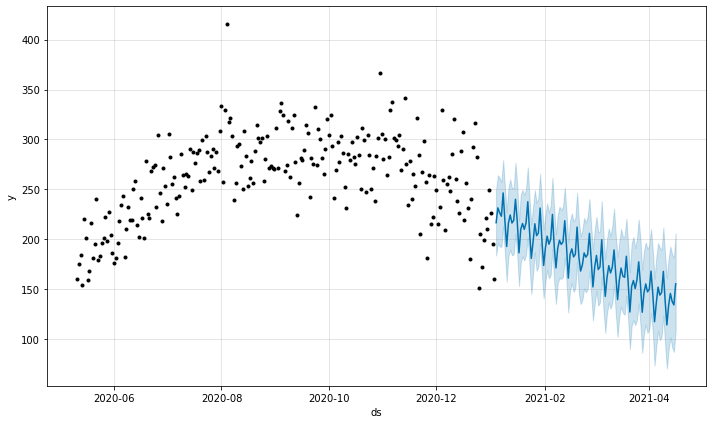

In [7]:
#plot predictions
import matplotlib.pyplot as plt

plt = m.plot(forecast)
#df1[['ds', 'y']].set_index('ds').plot(color='red')
plt.show()

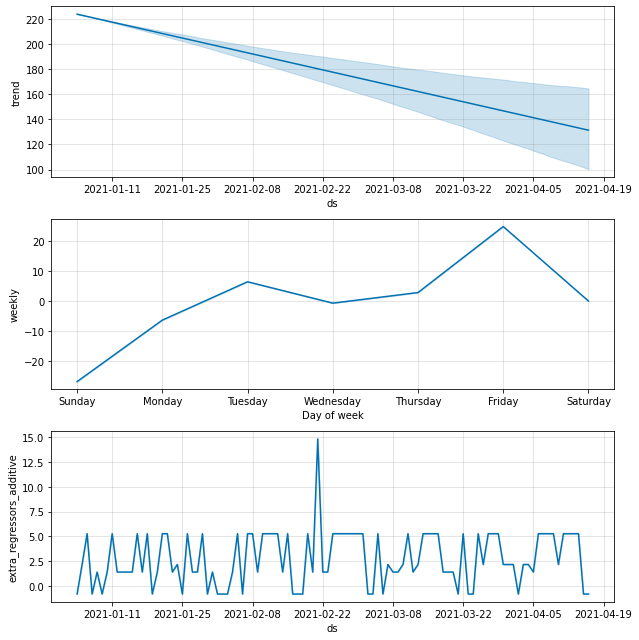

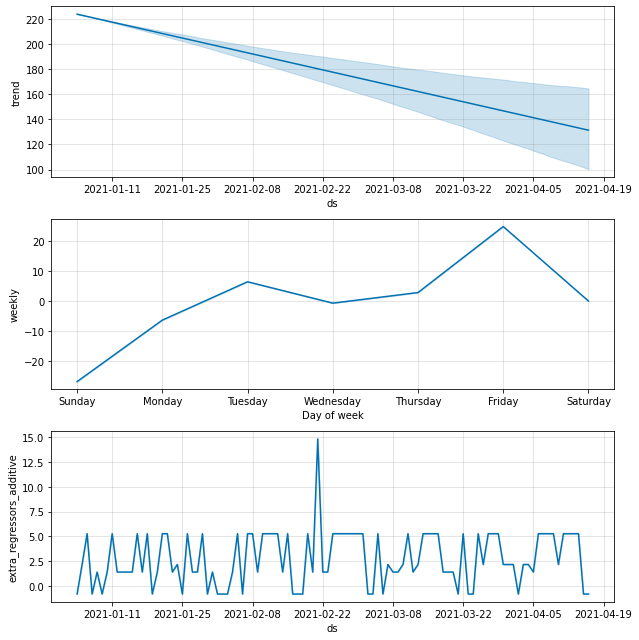

In [8]:
m.plot_components(forecast)

In [9]:
forecast['yhat']

0      216.580333
1      231.480687
2      226.549760
3      223.082939
4      246.447530
          ...    
98     133.867958
99     145.780367
100    137.738733
101    134.271911
102    155.413511
Name: yhat, Length: 103, dtype: float64

In [37]:
#Evaluating fbprohet predictions
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(forecast['yhat'], df_test['y'])
mse = mean_squared_error(forecast['yhat'], df_test['y'])
rmse = np.sqrt(mse)
print("Mean Absolute value for fbprophet predictions:" + str(mae))
print("Root Mean Square Error for fbprophet predictions:" + str(rmse))

Mean Absolute value for fbprophet predictions:53.27483276166276
Root Mean Square Error for fbprophet predictions:63.67667735501835


##**Prep datetime feature so we can pass on other ML models**

Observe that the the date_time constituents have great effect in predicting accidents, so they cannot be dropped. 
<br>Accidents counts are greater on rush hours and weekends.

In [11]:
#lets break apart the date and get the year, month, week, dayofweek
df1['ds'] = pd.to_datetime(df1['ds'])

df2 = df1
df2['year'] = df2['ds'].dt.year
df2['month'] = df2['ds'].dt.month
df2['week'] = df2['ds'].dt.week
df2['day'] = df2['ds'].dt.day
df2['dayofweek'] = df2['ds'].dt.dayofweek

df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,ds,y,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,year,month,week,day,dayofweek
0,2020-05-11,160,0,0,0,1,0,2020,5,20,11,0
1,2020-05-12,175,0,0,0,1,0,2020,5,20,12,1
2,2020-05-13,184,0,1,0,0,0,2020,5,20,13,2
3,2020-05-14,154,0,0,1,0,0,2020,5,20,14,3
4,2020-05-15,220,0,0,1,0,0,2020,5,20,15,4


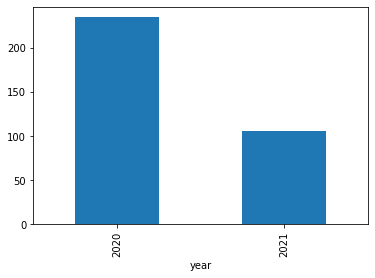

In [12]:
#lets explore our dates a bit

df2.groupby('year').size().plot(kind='bar')

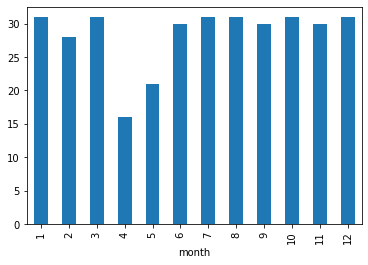

In [13]:
df2.groupby('month').size().plot(kind='bar')

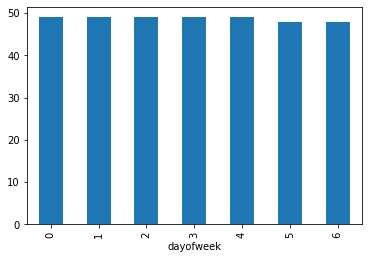

In [14]:
df2.groupby('dayofweek').size().plot(kind='bar', )

Observe from the above EDA that our dates are evenly distributed across dayofweek so we can be sure there are no size biases in our dates.<br>
Hence, we go ahead and shuffle our dataset since our datetime have been converted to features as order becomes irrelevant to our model in predicting the counts of accidents. 

In [15]:
#let's shuffle df2 to distribute ordered dates across randomly.
df3 = df2.sample(n=len(df2), random_state = 42).reset_index( drop= True)
df3.head()

,ds,y,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,year,month,week,day,dayofweek
0,2021-03-29,218,0,1,0,0,0,2021,3,13,29,0
1,2020-09-04,337,0,1,0,0,0,2020,9,36,4,4
2,2020-09-01,311,1,0,0,0,0,2020,9,36,1,1
3,2020-06-22,268,0,0,0,1,0,2020,6,26,22,0
4,2020-09-14,256,1,0,0,0,0,2020,9,38,14,0


In [16]:
X = df3.drop(columns= ['ds', 'y'], axis=1)
y = df3.y

In [17]:
#split data into train and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**b) RandomForest Regressor**

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf_forecast = rf.predict(X_test)
rf.score(X_test, y_test)

0.5553708466130127

In [40]:
#Evaluating RandomForestRegressor predictions
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(rf_forecast, y_test)
mse = mean_squared_error(rf_forecast, y_test)
rmse = np.sqrt(mse)
print("Mean Absolute Error for RandomForest predictions:" + str(mae))
print("Root Mean Square Error for RandomForest predictions:" + str(rmse))

Mean Absolute Error for RandomForest predictions:21.49650485436893
Root Mean Square Error for RandomForest predictions:28.75534574192882


**c) Using LinearRegression Model**

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_forecast = rf.predict(X_test)
lr.score(X_test, y_test)

0.0433769213227585

**Linearity Rule doesn't hold true:** Observe that our predictions does not follow a linear model as relationship between datapoints are not Linear.
<br>
Thus, LinearREgression performs terrible as seen above.

**d) Using KNN**

In [26]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

knn_forecast= knn.predict(X_test)

#let's evalueate knn
knn.score(X_test, y_test)

0.3424824485214748

**d)Using GradientBoosting**

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

gbr_forecast = gbr.predict(X_test)
gbr.score(X_test, y_test)

0.5490014721370398

In [28]:
y_test.shape

(103,)

In [29]:
from sklearn.metrics import mean_absolute_error
#Evaluating GradientBoostingRegressor predictions
mae = mean_absolute_error(gbr_forecast, y_test)
rmse = np.sqrt(mae)
print("Mean Absolute Error for RandomForest predictions:" + str(mae))
print("Root Mean Square Error for RandomForest predictions:" + str(rmse))

Mean Absolute Error for RandomForest predictions:20.695598860278423
Root Mean Square Error for RandomForest predictions:4.5492415697870365


**e) Let's use other estimators in sklearn**

In [30]:
from sklearn.utils.testing import all_estimators
from sklearn import base

estimators = all_estimators()

for name, class_ in estimators:
    if issubclass(class_, base.RegressorMixin):
        print(name+"()")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



ARDRegression()
AdaBoostRegressor()
BaggingRegressor()
BayesianRidge()
CCA()
DecisionTreeRegressor()
DummyRegressor()
ElasticNet()
ElasticNetCV()
ExtraTreeRegressor()
ExtraTreesRegressor()
GaussianProcessRegressor()
GradientBoostingRegressor()
HistGradientBoostingRegressor()
HuberRegressor()
IsotonicRegression()
KNeighborsRegressor()
KernelRidge()
Lars()
LarsCV()
Lasso()
LassoCV()
LassoLars()
LassoLarsCV()
LassoLarsIC()
LinearRegression()
LinearSVR()
MLPRegressor()
MultiOutputRegressor()
MultiTaskElasticNet()
MultiTaskElasticNetCV()
MultiTaskLasso()
MultiTaskLassoCV()
NuSVR()
OrthogonalMatchingPursuit()
OrthogonalMatchingPursuitCV()
PLSCanonical()
PLSRegression()
PassiveAggressiveRegressor()
RANSACRegressor()
RadiusNeighborsRegressor()
RandomForestRegressor()
RegressorChain()
Ridge()
RidgeCV()
SGDRegressor()
SVR()
StackingRegressor()
TheilSenRegressor()
TransformedTargetRegressor()
VotingRegressor()
_SigmoidCalibration()


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [31]:
n_r=0.6 
r_s=42 
np.random.seed(seed=r_s)

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,HistGradientBoostingRegressor
from sklearn.linear_model import Ridge,RidgeCV,BayesianRidge,LinearRegression,Lasso,LassoCV,ElasticNet,RANSACRegressor,HuberRegressor,PassiveAggressiveRegressor,ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import CCA
from sklearn.neural_network import MLPRegressor



my_regressors=[ 
               ElasticNet(alpha=0.001,l1_ratio=0.70,max_iter=100,tol=0.01, random_state=r_s),
               ElasticNetCV(l1_ratio=0.9,max_iter=100,tol=0.01,random_state=r_s),
               #GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber',random_state =r_s),
               #RandomForestRegressor(random_state=r_s),
               AdaBoostRegressor(random_state=r_s),
               #ExtraTreesRegressor(random_state=r_s),
               #SVR(C= 20, epsilon= 0.008, gamma=0.0003),
               Ridge(alpha=6),
               RidgeCV(),
               BayesianRidge(),
               DecisionTreeRegressor(),
               LinearRegression(),
               KNeighborsRegressor(),
               Lasso(alpha=0.00047,random_state=r_s),
               LassoCV(),
               #KernelRidge(),
               CCA(),
               MLPRegressor(random_state=r_s),
               HistGradientBoostingRegressor(random_state=r_s),
               HuberRegressor(),
               RANSACRegressor(random_state=r_s),
               PassiveAggressiveRegressor(random_state=r_s)
               #XGBRegressor(random_state=r_s)
              ]

regressors=[]

for my_regressor in my_regressors:
    regressors.append(my_regressor)


scores_val=[]
scores_train=[]
MAE=[]
MSE=[]
RMSE=[]


for regressor in regressors:
    scores_val.append(regressor.fit(X_train,y_train).score(X_test,y_test))
    scores_train.append(regressor.fit(X_train,y_train).score(X_train,y_train))
    y_pred=regressor.predict(X_test)
    MAE.append(mean_absolute_error(y_test,y_pred))
    MSE.append(mean_squared_error(y_test,y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test,y_pred)))

    
results=zip(scores_val,scores_train,MAE,MSE,RMSE)
results=list(results)
results_score_val=[item[0] for item in results]
results_score_train=[item[1] for item in results]
results_MAE=[item[2] for item in results]
results_MSE=[item[3] for item in results]
results_RMSE=[item[4] for item in results]


df_results=pd.DataFrame({"Algorithms":my_regressors,"Training Score":results_score_train,"Validation Score":results_score_val,"MAE":results_MAE,"MSE":results_MSE,"RMSE":results_RMSE})
df_results

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:321: UserWarning:

Y residual constant at iteration 1

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:321: UserWarning:

Y residual constant at iteration 1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



,Algorithms,Training Score,Validation Score,MAE,MSE,RMSE
0,"ElasticNet(alpha=0.001, copy_X=True, fit_inter...",0.268729,0.043446,31.308823,1778.889443,42.176883
1,"ElasticNetCV(alphas=None, copy_X=True, cv=None...",0.256666,0.074226,30.703544,1721.646994,41.492734
2,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.660056,0.473661,22.478027,978.824629,31.286173
3,"Ridge(alpha=6, copy_X=True, fit_intercept=True...",0.268551,0.048206,31.247658,1770.036581,42.071803
4,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.268360,0.050628,31.214389,1765.532055,42.018235
5,"BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...",0.259874,0.073597,30.814000,1722.816327,41.506823
6,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.000000,0.274582,30.699029,1444.038835,38.000511
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.268729,0.043377,31.309578,1779.017034,42.178395
8,"KNeighborsRegressor(algorithm='auto', leaf_siz...",0.598587,0.342482,26.807767,1222.775146,34.968202
9,"Lasso(alpha=0.00047, copy_X=True, fit_intercep...",0.268729,0.043397,31.309310,1778.979782,42.177954


Observe that just a few estimators scored above average. <br>
Top three estimators are  
<br>**RandomForest: Validation_Score= 0.552749604295966, RMSE=28.18891305846105** 
<br>**GradientBoostingRegressor: Validation_Score= 0.5479264, RMSE = 28.83998252830625**
<br>**HistGradientBoostingRegressor:  Validation_Score= 0.537750, RMSE= 29.319589**


##Applying GridSearchCV for Hyperparameter Tuning

In [32]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid_rf = {
    'bootstrap': [True],
    #'max_depth': [80, 90, 100, 110],
   # 'max_features': 'auto',
    'min_samples_leaf': [1, 3, 4, 5],
    'min_samples_split': [1,2,3,4,5],
    'n_estimators': [50, 100, 200, 300]
    }
param_grid_gb = {'alpha':[0.7, 0.8,0.9,1],
                 'learning_rate':[0.05, 0.1, 0.15],
                 'n_estimators': [50, 100,150,200],
                 'min_samples_split':[1,2,3,4],
                 'min_samples_leaf':[1,2,3],
                 'tol':[0.00001, 0.0001, 0.001],
                 'max_depth':[2,3,4,5],
                 'validation_fraction':[0.05,0.1,0.15]
                 }
# Create a based model
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search_gb = GridSearchCV(estimator=gb, param_grid= param_grid_gb, cv=5, n_jobs=-1, verbose=2)


In [33]:
grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 20736 candidates, totalling 103680 fits


[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 2628 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4240 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6508 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 8398 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 14410 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 17736 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 22142 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 25810 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 31610 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 37396 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 43320 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 49491 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 55972 tasks      | 

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
             iid='deprecated

In [34]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)

{'bootstrap': True, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
0.5180506613176356
{'alpha': 0.7, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'tol': 0.0001, 'validation_fraction': 0.05}
0.5549640257108767


##**Re-fit data to best estimators**
We observe that gridsearchcv makes no significant difference with our model accuracy score.

Thus, we go ahead with RandomForest bare model cos its has the optimal score.

In [35]:
#re-fit into RandomForest estimator
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5559826134226538

In [36]:
#make predictions and find mae, and rmse

rf_predict = rf.predict(X_test)
mae = mean_absolute_error(y_test, rf_predict)
mse = mean_squared_error(y_test, rf_predict)
rmse = np.sqrt(mse)
print(mse)
print(rmse)

825.7322155339807
28.735556642145994


We immediately observe from the score, mae and rmse above for Ramdomforest estimator is better than all other ML estimators triesd ealier.<br>

**Let's return the dataset to it's original form and plot**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



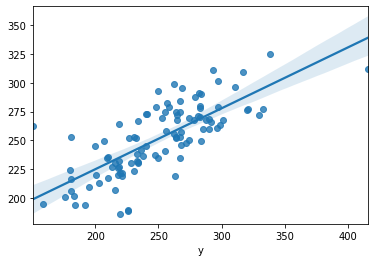

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(y_test, rf_forecast)
plt.show()

In [42]:
regen_df = pd.concat([X_test, y_test], axis=1).assign(Predicted = rf_predict).sort_values(by=['year', 'month', 'week', 'dayofweek'])
regen_df.head()

,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,year,month,week,day,dayofweek,y,Predicted
229,0,0,1,0,0,2020,5,20,15,4,220,191.15
114,0,1,0,0,0,2020,5,20,17,6,159,199.70
19,0,0,0,1,0,2020,5,21,20,2,181,207.31
124,0,1,0,0,0,2020,5,21,21,3,195,207.84
299,0,0,0,1,0,2020,5,21,24,6,183,202.52


In [43]:
cols=["year","month","day"]
regen_df['date'] = regen_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
regen_df['date'] =pd.to_datetime(regen_df['date'])

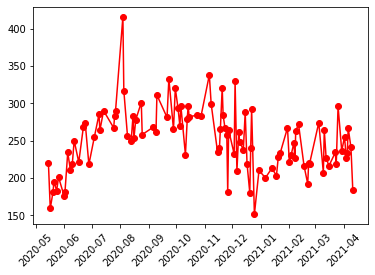

In [46]:
#plot the resorted datesets from RandomForest predictions and plot
plt.scatter(regen_df['date'], regen_df['y'], color='red')
plt.plot(regen_df['date'], regen_df['y'], color='red')
plt.xticks(rotation=45)
plt.show()

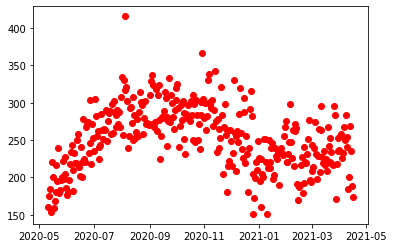

In [ ]:
#plot original dataset scatter plot. 
#we observe RandomForest model does a better job than all other models when compared to its original data. 
plt.scatter(df1['ds'], df1['y'], color='red')
plt.show()

##**Conclusion**

In this regressor problem, we have attempted to predict the number of accidents in NewYork City:
* After trying multiple machine learning models and using a cross validation technique, we have chosen the best performed model: RandomForestRegressor
*Our metrics for choosing our model was Mean absolute error, root mean squared error and the training and validation score.
